In [2]:
# Importing libraries

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import monotonically_increasing_id, to_timestamp, row_number, rand, col, date_format, when
from pyspark.sql.window import Window
import glob
import subprocess
import pandas as pd
import pyarrow.hdfs as hdfs

In [59]:


data_path = "/home/hduser/Desktop/CA2/Data/Unzipped/"
hdfs_data_path = "/CA2/Data/Unzipped/"
columns = ["dailyRecordId","userid","tweetid","text","hashtags","language"]
schema = StructType([StructField(col, StringType(), True) for col in columns])
datetimeHeader = "tweetcreatedts"
columns.append(datetimeHeader)
print(columns)
datetimeColumn = StructField(datetimeHeader, TimestampType(), True)
schema = StructType(schema.fields + [datetimeColumn])

spark = SparkSession.builder.appName("CSVtoSpark").getOrCreate()
fs = hdfs.connect(host='localhost', port=9000, user='hduser')


['dailyRecordId', 'userid', 'tweetid', 'text', 'hashtags', 'language', 'tweetcreatedts']


/tmp/ipykernel_6709/4159024334.py:21: FutureWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  fs = hdfs.connect(host='localhost', port=9000, user='hduser')


In [60]:
def loadNormalisedDf(path):
    temp_df = spark.read.csv(path, header=True)
    return temp_df

def setColumns(df):
    df = df.withColumnRenamed("_c0", "dailyRecordId")
    df = df.withColumn('timestamp',
                   when(to_timestamp(datetimeHeader, 'yyyy-MM-dd HH:mm:ss.SSSSSS').isNotNull(),
                        to_timestamp(datetimeHeader, 'yyyy-MM-dd HH:mm:ss.SSSSSS'))
                   .when(to_timestamp(datetimeHeader, 'MMM-dd-yyyy HH:mm:ss').isNotNull(),
                         to_timestamp(datetimeHeader, 'MMM-dd-yyyy HH:mm:ss')))
    df = df.withColumn(datetimeHeader, date_format(datetimeHeader, "yyyy-MM-dd"))
    df = df.filter(df.tweetcreatedts.isNotNull())
    result_df = df.select(columns).filter("language = 'en'")
    sampled_df = result_df.sample(0.001, seed=42).limit(30)   
    return sampled_df

def takeSamplePerDate(df, noOfSamples):
    print("Number of records before filtering is " + str(df.count()))
    w = Window.partitionBy(datetimeHeader).orderBy(rand())
    df_with_id = df.withColumn('row_id', row_number().over(w))
    df_with_id = df_with_id.filter(df_with_id.row_id <= noOfSamples)
    print("Number of records after filtering is " + str(df_with_id.count()))
    return df_with_id.drop('row_id')

# this method ignores the value of datetimeHeader and must be updated manually if that value changes
def RemoveNullDates(df):
    date = df.filter(df.tweetcreatedts.isNotNull()).select("tweetcreatedts").first()[0]
    return df.fillna({"tweetcreatedts": date})

In [61]:
def getAllFilePaths(directory):
    files = glob.glob(directory + "*.csv")
    print(files)
    return files

def getAllHdfsPaths(hdfs_directory):
    # declare the hadoop fs -ls command to list all CSV files in the directory
    cmd = "hadoop fs -ls {}/*.csv | awk '{{print $NF}}'".format(hdfs_data_path)
    
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    
    output = proc.stdout.read().decode() # read output and decode byte stream
    output = output.strip().split() # remove whitespace and convert to array and return
    return output

#print(csv_paths)

In [62]:
df_combined = spark.createDataFrame([], schema)
panda_df = pd.DataFrame()
for path in getAllHdfsPaths(data_path):
    if fs.exists(path):
        new_df = loadNormalisedDf(path)
        new_df = setColumns(new_df)
        converted_df = new_df.toPandas()       
        panda_df = pd.concat([panda_df, converted_df], ignore_index=True)
print(panda_df.shape)

2023-05-04 21:54:39,952 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0401_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:54:44,504 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0402_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:54:48,117 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 21:56:26,358 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0425_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:56:29,465 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0426_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:56:32,614 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 21:57:59,097 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0521_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:58:08,746 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0522_UkraineCombinedTweetsDeduped.csv
2023-05-04 21:58:18,110 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:01:44,472 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0616_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:01:50,094 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0617_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:01:55,641 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:03:47,609 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0710_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:03:51,861 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0711_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:03:56,761 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:05:29,462 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0803_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:05:35,328 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0804_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:05:39,165 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:06:20,217 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0827_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:06:21,503 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0828_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:06:22,624 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:07:00,677 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0920_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:03,921 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/0921_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:08,638 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:07:58,419 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1014_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:07:59,988 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1015_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:01,500 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:08:33,381 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1107_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:35,049 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1108_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:08:36,404 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:09:12,969 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1201_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:14,614 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1202_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:16,388 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:09:50,173 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1225_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:52,362 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/1226_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:09:53,899 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/

2023-05-04 22:10:25,458 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230118_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:10:26,816 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230119_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:10:28,185 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:12:17,496 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230305_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:12:20,853 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230306_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:12:25,023 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:15:16,104 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230421_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:15:17,393 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/20230422_UkraineCombinedTweetsDeduped.csv
2023-05-04 22:15:19,152 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/C

2023-05-04 22:16:19,141 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/UkraineCombinedTweetsDeduped_MAR13.csv
2023-05-04 22:16:21,519 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Data/Unzipped/UkraineCombinedTweetsDeduped_MAR14.csv
2023-05-04 22:16:24,100 WARN csv.CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userid, tweetid, tweetcreatedts, text, hashtags, language
 Schema: _c0, userid, tweetid, tweetcreatedts, text, hashtags, language
Expected: _c0 but found: 
CSV file: hdfs://localhost:9000/CA2/Dat

(7504, 7)


In [63]:
panda_df.head(4)

,dailyRecordId,userid,tweetid,text,hashtags,language,tweetcreatedts
0,27067,891030643135610881,1509720862840213509,"""#Ukraine: Various previously unseen Russian l...","[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
1,27551,1166303518870761473,1509721671787196444,"""#Ukraine: Another Ukrainian ambush against Ru...","[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
2,28405,1496705355988054016,1509723106574749701,#Ukraine: Here is video from this position in ...,"[{'text': 'Ukraine', 'indices': [15, 23]}, {'t...",en,2022-04-01
3,31154,23917612,1509727113917739013,Fascist Russia has neither legal nor moral rig...,"[{'text': 'Ukraine', 'indices': [90, 98]}, {'t...",en,2022-04-01


In [64]:
panda_df = panda_df.sort_values(by='tweetcreatedts')

In [67]:
print(panda_df['tweetcreatedts'].head(1))
print(panda_df['tweetcreatedts'].tail(1))
print(panda_df.size)
print(panda_df.shape)

6513    2022-02-24
Name: tweetcreatedts, dtype: object
6483    2023-04-28
Name: tweetcreatedts, dtype: object
52528
(7504, 7)


In [70]:
unique_count = panda_df['tweetcreatedts'].nunique()
print(unique_count)

422


In [66]:
def testSingleFile(path): 
    print(path)
    new_df = loadNormalisedDf(path)
    #new_df = setColumns(new_df)
    df = new_df.withColumnRenamed("_c0", "dailyRecordId")
    #df.select('tweetcreatedts').show()
    #df.show()
    #df = df.withColumn(datetimeHeader, to_timestamp(datetimeHeader, "yyyy-MM-dd HH:mm:ss.SSSSSS"))
    
    df = df.withColumn(datetimeHeader, date_format(datetimeHeader, "yyyy-MM-dd"))
    df = df.filter(df.tweetcreatedts.isNotNull())
    #df.show()
    
    df.select('tweetcreatedts').show()
    #result_df = df.select(columns).filter("language = 'en'")
    #sampled_df = result_df.sample(0.001, seed=42).limit(30)   
    
    
#files = getAllHdfsPaths(data_path)
#path = files[-1]
#testSingleFile('/CA2/Data/Unzipped/20230106_UkraineCombinedTweetsDeduped.csv')

In [71]:
import os

# get the current working directory
cwd = os.getcwd()

# print the current working directory
print("Current working directory:", cwd)

Current working directory: /home/hduser/Desktop/CA2


In [73]:

# save the dataframe to a CSV file
panda_df.to_csv('outputWithoutIndex.csv', index=False)
panda_df.to_csv('outputWithIndex.csv', index=True)

In [98]:
# Load in csv
df = pd.read_csv('outputWithIndex.csv')

In [46]:
# Initial exploratory data anaylsis
df.head()

,Unnamed: 0,dailyRecordId,userid,tweetid,text,hashtags,language,tweetcreatedts
0,6513,220323,1298290459459149824,1496932267863654400,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,"[{'text': 'RussiaUkraine', 'indices': [67, 81]...",en,2022-02-24
1,6512,220106,1429579691258650624,1496932211097931778,#Ukraine #Russia I think we should let @Hasbul...,"[{'text': 'Ukraine', 'indices': [0, 8]}, {'tex...",en,2022-02-24
2,6511,217550,1265082391179202561,1496928912219193344,Russian media reports that “No to war” graffit...,"[{'text': 'Moscow', 'indices': [95, 102]}]",en,2022-02-24
3,6510,215047,1177659309213257728,1496926647911858176,@StratcomCentre Kick some fucking ass #Ukraine,"[{'text': 'Ukraine', 'indices': [38, 46]}]",en,2022-02-24
4,6509,191232,2601989537,1496906278416834563,Do the Russian people like #putin ? #russia,"[{'text': 'putin', 'indices': [27, 33]}, {'tex...",en,2022-02-24


In [47]:
df.shape # 7504 rows and 8 columns

(7504, 8)

In [48]:
df.dtypes

Unnamed: 0         int64
dailyRecordId     object
userid            object
tweetid            int64
text              object
hashtags          object
language          object
tweetcreatedts    object
dtype: object

In [49]:
df.dtypes

Unnamed: 0         int64
dailyRecordId     object
userid            object
tweetid            int64
text              object
hashtags          object
language          object
tweetcreatedts    object
dtype: object

In [50]:
df.describe(include=object)

,dailyRecordId,userid,text,hashtags,language,tweetcreatedts
count,7504,7504,7504,7504,7504,7504
unique,7372,6598,6910,5654,1,422
top,50558,236770150,I’m DONE talking. #JoinTheLegion #StopRussi...,[],en,2022-02-28
freq,4,21,13,510,7504,60


In [51]:
df.describe()

,Unnamed: 0,tweetid
count,7504.000000,7.504000e+03
mean,3751.500000,1.557782e+18
std,2166.362543,4.649140e+16
min,0.000000,1.496778e+18
25%,1875.750000,1.519924e+18
50%,3751.500000,1.544212e+18
75%,5627.250000,1.593299e+18
max,7503.000000,1.651999e+18


In [52]:
# dealing with null values
df.isnull().values.any()

False

In [53]:
# Natural language processing
# extracting number of words per tweet
df['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))

In [54]:
df[['text','word_count']].head()

,text,word_count
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,11
1,#Ukraine #Russia I think we should let @Hasbul...,16
2,Russian media reports that “No to war” graffit...,16
3,@StratcomCentre Kick some fucking ass #Ukraine,6
4,Do the Russian people like #putin ? #russia,9


In [55]:
df['char_count'] = df['text'].str.len() 

In [56]:
## this also includes spaces
df[['text','char_count']].head()

,text,char_count
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,94
1,#Ukraine #Russia I think we should let @Hasbul...,101
2,Russian media reports that “No to war” graffit...,112
3,@StratcomCentre Kick some fucking ass #Ukraine,46
4,Do the Russian people like #putin ? #russia,44


In [57]:
# average word length per tweet
def avg_word(sentence):
  words = sentence.split()
  return (sum(len(word) for word in words)/len(words))

In [58]:
df['avg_word'] = df['text'].apply(lambda x: avg_word(x))

In [59]:
df[['text','avg_word']].head()

,text,avg_word
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,7.636364
1,#Ukraine #Russia I think we should let @Hasbul...,5.375000
2,Russian media reports that “No to war” graffit...,6.062500
3,@StratcomCentre Kick some fucking ass #Ukraine,6.833333
4,Do the Russian people like #putin ? #russia,4.500000


In [60]:
# number of stop words
#!pip install nltk


In [61]:
import nltk

In [62]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hduser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [64]:
df['stopwords'] = df['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['text','stopwords']].head()

,text,stopwords
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,1
1,#Ukraine #Russia I think we should let @Hasbul...,7
2,Russian media reports that “No to war” graffit...,5
3,@StratcomCentre Kick some fucking ass #Ukraine,1
4,Do the Russian people like #putin ? #russia,1


In [65]:
# special characters
df['hastags'] = df['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
df[['text','hastags']].head()

,text,hastags
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,2
1,#Ukraine #Russia I think we should let @Hasbul...,2
2,Russian media reports that “No to war” graffit...,1
3,@StratcomCentre Kick some fucking ass #Ukraine,1
4,Do the Russian people like #putin ? #russia,2


In [66]:
df['numerics'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
df[['text','numerics']].head(20)

,text,numerics
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,0
1,#Ukraine #Russia I think we should let @Hasbul...,0
2,Russian media reports that “No to war” graffit...,0
3,@StratcomCentre Kick some fucking ass #Ukraine,0
4,Do the Russian people like #putin ? #russia,0
5,Rocket launch from Russian Krasnodar towards #...,0
6,Place of battle. Russian and Ukrainian armored...,0
7,So what's the over/under on #NATO involvement,0
8,In the 24 hours after Putin recognized two bre...,1
9,#USA trying to help #Ukraine https://t.co/UXqB...,0


In [67]:
# number of capitalised words
df['upper'] = df['text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))
df[['text','upper']].head()

,text,upper
0,My heart breaks for Ukraine. STAY STRONG. 🇺🇦🇮🇱...,2
1,#Ukraine #Russia I think we should let @Hasbul...,1
2,Russian media reports that “No to war” graffit...,0
3,@StratcomCentre Kick some fucking ass #Ukraine,0
4,Do the Russian people like #putin ? #russia,0


In [68]:
# Precprocessing: turn all text into lower case
df['text'] = df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['text'].head()

0    my heart breaks for ukraine. stay strong. 🇺🇦🇮🇱...
1    #ukraine #russia i think we should let @hasbul...
2    russian media reports that “no to war” graffit...
3       @stratcomcentre kick some fucking ass #ukraine
4          do the russian people like #putin ? #russia
Name: text, dtype: object

In [69]:
# remove punctuation
df['text'] = df['text'].str.replace('[^\w\s#@]','')
df['text'].head()
# for some reason this code did not remove the # and @ symbols as it did in David's script

0    my heart breaks for ukraine. stay strong. 🇺🇦🇮🇱...
1    #ukraine #russia i think we should let @hasbul...
2    russian media reports that “no to war” graffit...
3       @stratcomcentre kick some fucking ass #ukraine
4          do the russian people like #putin ? #russia
Name: text, dtype: object

In [70]:
import string
# Define a function to remove all punctuation characters
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Apply the function to the text column
df['text'] = df['text'].apply(remove_punctuation)

print(df)

      Unnamed: 0 dailyRecordId               userid              tweetid   
0           6513        220323  1298290459459149824  1496932267863654400  \
1           6512        220106  1429579691258650624  1496932211097931778   
2           6511        217550  1265082391179202561  1496928912219193344   
3           6510        215047  1177659309213257728  1496926647911858176   
4           6509        191232           2601989537  1496906278416834563   
...          ...           ...                  ...                  ...   
7499        6479         83535            815836723  1650623150730747909   
7500        6480         62759  1262482848768045060  1650901338711117824   
7501        6481         46449   959907715094122497  1651268007199490066   
7502        6482         47276            134189106  1651629845212798980   
7503        6483         43608  1498004265603850247  1651998728943808533   

                                                   text   
0     my heart breaks for uk

In [71]:
# removign the stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['text'].head()

0    heart breaks ukraine stay strong 🇺🇦🇮🇱 russiauk...
1    ukraine russia think let hasbullahive abdurozi...
2    russian media reports “no war” graffitis appea...
3              stratcomcentre kick fucking ass ukraine
4                     russian people like putin russia
Name: text, dtype: object

In [72]:
# identifying the 10 most common words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[:10]
freq

ukraine      3515
russia       1808
russian      1502
amp           963
war           865
ukrainian     777
putin         706
people        510
us            505
world         464
Name: count, dtype: int64

In [73]:
# choosing not to remove the most common words as they may help in the calssification of data

In [74]:
# dealing with rare words
freq = pd.Series(' '.join(df['text']).split()).value_counts()[-1000:]
freq

🇺🇦ukrainerussianwar    1
amman                  1
🇯🇴                     1
tajlifestylecenter     1
naturalpackaging       1
                      ..
discover               1
📌                      1
erhn                   1
httpstcop9nyrqwqbj     1
httpstcokadl1agzpw     1
Name: count, Length: 1000, dtype: int64

In [75]:
total_words = df['text'].str.split().apply(len).sum()
print(f"Total number of words in the 'text' column: {total_words}")

Total number of words in the 'text' column: 133535


In [76]:
# Rare words can cause noise or loss of signal in the analysis.In this dataset there are likely a large number of 
# rare words. However, they may also be important for understanding the sentiment analysis. 

# Going to make two dataset and sentiment analysis, to see how the rare words affect the outcome.
# Based on looking at the freq output (and changing the output) it looks like it would be better to remove the
# the rare words. But I'll conduct the analysis and see.

In [77]:
# see how many times ur comes up
# pattern to match standalone "ur"

import re

pattern = r"(?<!\S)ur(?!\S)"

# function to count "ur" as a standalone word
def count_ur(text):
    return len(re.findall(pattern, text))

# apply the count_ur function to the 'text' column and sum the results
ur_count = df['text'].apply(count_ur).sum()

# print the total count of "ur" as a standalone word
print(ur_count)

5


In [78]:
# Remove the word ur and replace with your
# pattern to match standalone "ur"
pattern = r"(?<!\S)ur(?!\S)"

# function to replace "ur" with "your"
def replace_ur(text):
    return re.sub(pattern, "your", text)

# replace "ur" with "your" using the pattern and function
df['text'] = df['text'].apply(replace_ur)

In [79]:
# apply the count_ur function to the 'text' column and sum the results
ur_count = df['text'].apply(count_ur).sum()

# print the total count of "ur" as a standalone word
print(ur_count)

0


In [35]:
# Correcting spelling mistakes
# installing textblob
#!pip install -U textblob 

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 KB 3.1 MB/s eta 0:00:00 MB/s eta 0:00:01


In [80]:
from textblob import TextBlob
df['text'].apply(lambda x: str(TextBlob(x).correct()))

KeyboardInterrupt: 

In [ ]:
# stopped the textblob corrections. The size the of the dataframe was too big. 

In [83]:
!pip install nltk.sentiment.vader

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement nltk.sentiment.vader (from versions: none)
ERROR: No matching distribution found for nltk.sentiment.vader


In [84]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/hduser/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [99]:
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def percentage(part, whole):
    return 100 * float(part) / float(whole)


# noOfTweet = int(input("10"))
# noOfTweet = int(input("100"))
noOfTweet = len(df['text'])
#tweet_list = df['text'].tolist()
tweet_list = [(row['text'], row['tweetcreatedts']) for _, row in df.iterrows()]
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
dateAndScore_list = []

counter = 0

for tweet_text in tweet_list:
    counter += 1
    analysis = TextBlob(tweet_text[0])
    score = SentimentIntensityAnalyzer().polarity_scores(tweet_text[0])
    neg = score['neg']
    #print("Negative score is " + str(neg))
    neu = score['neu']
    #print("Neutral score is " + str(neu))
    pos = score['pos']
    #print("Positive score is " + str(pos))
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    if neg > pos:
        negative_list.append(tweet_text[1])
        negative += 1
        dateAndScore_list.append([tweet_text[1], "neg"])
    elif pos > neg:
        positive_list.append(tweet_text[1])
        positive += 1
        dateAndScore_list.append([tweet_text[1], "pos"])
    elif pos == neg:
        neutral_list.append(tweet_text[1])
        neutral += 1
        dateAndScore_list.append([tweet_text[1], "neu"])
    
print("neutral = " + str(neutral))
print("positive = " + str(positive))
print("negative = " + str(negative))

neutral = 1544
positive = 2505
negative = 3455


In [100]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  7504
positive number:  2505
negative number:  3455
neutral number:  1544


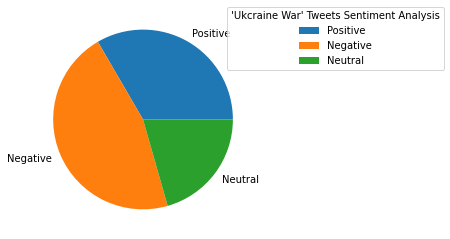

In [101]:
import matplotlib.pyplot as plt
import numpy as np

y = np.array([len(positive_list), len(negative_list), len(neutral_list)])
mylabels = ["Positive", "Negative", "Neutral"]

plt.pie(y, labels = mylabels)
plt.legend(title = "'Ukcraine War' Tweets Sentiment Analysis", loc="upper left", bbox_to_anchor=(0.85,1.025), )
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.75)
plt.show() 

In [102]:
# Time series Analysis

In [118]:
df = pd.DataFrame(dateAndScore_list, columns=['Date', 'Analysis'])

#date_analysis_count = df.groupby('Date')['Analysis'].value_counts()
#positive_percentage = (date_analysis_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).loc[:, 'pos']
#positive_percentage = (date_analysis_count.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))).get(('pos'), 0)
positive_percentage = df.groupby('Date')['Analysis'].apply(lambda x: (x == 'pos').mean() * 100)


#print(date_analysis_count)
print(type(positive_percentage))
print(positive_percentage)


<class 'pandas.core.series.Series'>
Date
2022-02-24     20.000000
2022-02-27     40.000000
2022-02-28     33.333333
2022-03-01     23.333333
2022-03-02     46.666667
                 ...    
2023-04-24      0.000000
2023-04-25    100.000000
2023-04-26      0.000000
2023-04-27    100.000000
2023-04-28      0.000000
Name: Analysis, Length: 422, dtype: float64


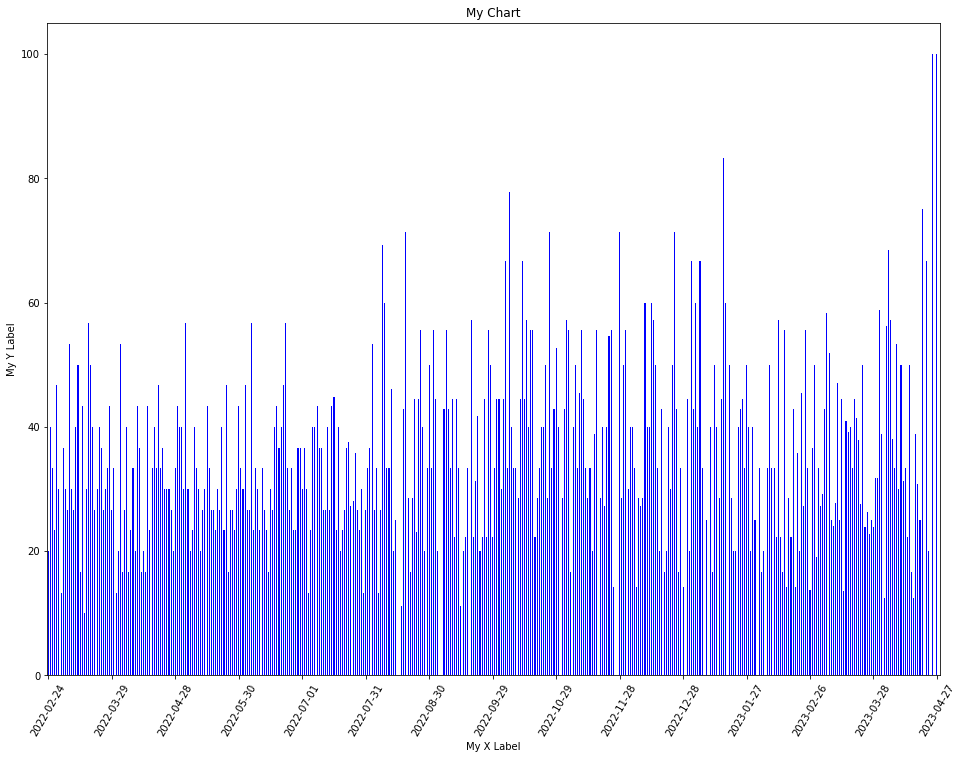

In [120]:
ax = positive_percentage.plot.bar(color='blue', title='My Chart', xlabel='My X Label', ylabel='My Y Label', figsize=(16, 12))

ax.set_xticks(ax.get_xticks()[::30])
plt.xticks(rotation=60)
plt.show()